In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Necessary Imports

In [1]:
!pip install git+https://github.com/Mahmoodlab/CONCH.git

  Cloning https://github.com/Mahmoodlab/CONCH.git to /tmp/pip-req-build-82y41r5q
  Running command git clone --filter=blob:none --quiet https://github.com/Mahmoodlab/CONCH.git /tmp/pip-req-build-82y41r5q
  Resolved https://github.com/Mahmoodlab/CONCH.git to commit f7bed1c32b4365feb2c65eb4231ae211ee19354f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 90.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.5 MB/s eta 0:00:00
  Created wheel for conch: filename=conch-0.1.0-py3-none-any.

In [2]:
import os
from pathlib import Path
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

from conch.open_clip_custom import create_model_from_pretrained

# Clear Directory

In [12]:
import os
import shutil

def clear_directory(directory_path):
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# Example usage
train_dir = 'train'
test_dir = 'test'

# Clear the contents of the train and test directories
clear_directory('/kaggle/working/')
# clear_directory(test_dir)

print("Directories have been cleared.")


Directories have been cleared.


# Reorganizing Data

In [13]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image  # Import PIL to check image validity

# Load the labels
df = pd.read_csv('/kaggle/input/wsi-msi-mss-labels/labels.csv')

# Initialize lists
all_msi_paths = []
all_mss_paths = []

# Traverse the directories and collect file paths
base_dir = '/kaggle/input/patched-dataset-wsi-for-kat'
for dir_name in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, dir_name)):
        patient_id = dir_name[:12]
        is_msih = False
        for i in range(len(df)):
            s = df['PATIENT'][i]
            if s.startswith(patient_id):
                if df['isMSIH'][i] == 'MSIH':
                    is_msih = True
                    break

        full_path = os.path.join(base_dir, dir_name, 'Overview/')
        if is_msih:
            all_msi_paths.append((full_path, patient_id))
        else:
            if len(all_mss_paths) < 28:
                all_mss_paths.append((full_path, patient_id))

print(f"Total MSI paths: {len(all_msi_paths)}")
print(f"Total MSS paths: {len(all_mss_paths)}")

# Function to count files in a directory
def count_files(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

# Calculate the total number of patches
msi_patches = sum(count_files(path) for path, _ in all_msi_paths)
mss_patches = sum(count_files(path) for path, _ in all_mss_paths)

print(f"Total MSI patches: {msi_patches}")
print(f"Total MSS patches: {mss_patches}")

# Check if lists are not empty
if all_msi_paths and all_mss_paths:
    # Split the paths into train and test sets
    train_msi, test_msi = train_test_split(all_msi_paths, test_size=0.4, random_state=42)
    train_mss, test_mss = train_test_split(all_mss_paths, test_size=0.4, random_state=42)

    # Define destination directories
    train_dir = 'train'
    test_dir = 'test'

    # Create the directory structure for train and test
    for directory in [train_dir, test_dir]:
        os.makedirs(os.path.join(directory, 'msi'), exist_ok=True)
        os.makedirs(os.path.join(directory, 'mss'), exist_ok=True)

    # Function to create directory structure and copy files
    def copy_files_with_appended_names(source_paths, destination_subdir):
        for source, patient_id in source_paths:
            for root, dirs, files in os.walk(source):
                for file in files:
                    source_file_path = os.path.join(root, file)
                    new_file_name = f"{patient_id}_{file}"
                    destination_file_path = os.path.join(destination_subdir, new_file_name)
                    os.makedirs(os.path.dirname(destination_file_path), exist_ok=True)
                    
                    try:
                        # Check if the file is a valid image
                        with Image.open(source_file_path) as img:
                            img.verify()  # Verify that it is an image
                        
                        shutil.copy2(source_file_path, destination_file_path)
#                         print(f"Copied {source_file_path} to {destination_file_path}")
                    
                    except Exception as e:
                        print(f"Skipping {source_file_path}. Reason: {e}")

    # Copy files to train directory
    copy_files_with_appended_names(train_msi, os.path.join(train_dir, 'msi'))
    copy_files_with_appended_names(train_mss, os.path.join(train_dir, 'mss'))

    # Copy files to test directory
    copy_files_with_appended_names(test_msi, os.path.join(test_dir, 'msi'))
    copy_files_with_appended_names(test_mss, os.path.join(test_dir, 'mss'))

    # Calculate and print the number of patches in train and test sets
    train_msi_patches = sum(count_files(path) for path, _ in train_msi)
    test_msi_patches = sum(count_files(path) for path, _ in test_msi)
    train_mss_patches = sum(count_files(path) for path, _ in train_mss)
    test_mss_patches = sum(count_files(path) for path, _ in test_mss)

    print(f"Train MSI patches: {train_msi_patches}")
    print(f"Test MSI patches: {test_msi_patches}")
    print(f"Train MSS patches: {train_mss_patches}")
    print(f"Test MSS patches: {test_mss_patches}")

    print("Files have been copied successfully with appended names and train-test split.")
else:
    print("Error: One of the lists (MSI or MSS) is empty. Cannot perform train-test split.")


Total MSI paths: 28
Total MSS paths: 28
Total MSI patches: 23641
Total MSS patches: 19517
Train MSI patches: 12827
Test MSI patches: 10814
Train MSS patches: 10156
Test MSS patches: 9361
Files have been copied successfully with appended names and train-test split.


In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/wsi-msi-mss-labels/labels.csv')
# print(df.iloc[452])
# print(df.iloc[0])
a = 'TCGA-AD-6964'
b = 'TCGA-SS-A7HO'
a1 = 'TCGA-4N-A93T'
b1 = 'TCGA-QG-A5Z2'

d = 'TCGA-3L-AA1B' 
c = 'TCGA-WS-AB45'

e= 'TCGA-A6-5661'
f= 'TCGA-A6-5666'


for i in range(len(df)):
    s = df['PATIENT'][i]
    if s.startswith(a):
        print('a: ', df['isMSIH'][i])
    if s.startswith(b):
        print('b: ', df['isMSIH'][i])
    
    if s.startswith(a1):
        print('a1: ', df['isMSIH'][i])
    if s.startswith(b1):
        print('b1: ', df['isMSIH'][i])
    
    if s.startswith(c):
        print('c: ', df['isMSIH'][i])
    if s.startswith(d):
        print('d: ', df['isMSIH'][i])
    if s.startswith(e):
        print('e: ', df['isMSIH'][i])
    if s.startswith(f):
        print('f: ', df['isMSIH'][i])

import shutil
# Define the path to the directory you want to delete
directory_to_delete = 'test'

# Delete the directory and all its contents
shutil.rmtree(directory_to_delete)

print(f"Directory '{directory_to_delete}' and all its contents have been deleted.")


In [ ]:
import os
import shutil

# Define source and destination paths
source_msi = [
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-WS-AB45-01Z-00-DX1.1FD99E7A-830F-40DC-98CD-53C62C678AC6/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-QG-A5Z2-01Z-00-DX1.51896C31-235E-48EF-90F7-FC05350CA564/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-A6-2686-01Z-00-DX1.0540a027-2a0c-46c7-9af0-7b8672631de7/Overview/'
]
source_mss = [
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-A6-2681-01Z-00-DX1.5e11f090-a19d-4d5c-bcf6-c219b55d02bc/Overview/',
    '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-A6-4107-01Z-00-DX1.89bf3dd5-72a6-49cc-9857-df2c36884029/Overview/'
]

destination_dir = 'train'

# source_msi = ['/kaggle/input/patched-dataset-wsi-for-kat/TCGA-AD-6964-01Z-00-DX1.83AF88B9-C59B-48C6-A739-85ACB8F8ECA9/Overview/',
#              '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-A6-5661-01Z-00-DX1.bad2d858-11b4-4b9c-a720-daaae592cf48/Overview/']
# source_mss = ['/kaggle/input/patched-dataset-wsi-for-kat/TCGA-SS-A7HO-01Z-00-DX1.D20B9109-F984-40DE-A4F1-2DFC61002862/Overview/',
#              '/kaggle/input/patched-dataset-wsi-for-kat/TCGA-A6-5666-01Z-00-DX1.6f2cf971-edcb-415d-9709-feb7422cddc4/Overview/']
# destination_dir = 'test'

# Create the directory structure
os.makedirs(os.path.join(destination_dir, 'msi'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'mss'), exist_ok=True)

# Function to copy files with appended names
def copy_files_with_appended_names(source_paths, destination_subdir):
    for source in source_paths:
        identifier = source[42:54]
        for root, dirs, files in os.walk(source):
            for file in files:
                source_file_path = os.path.join(root, file)
                new_file_name = f"{identifier}_{file}"
                destination_file_path = os.path.join(destination_dir, destination_subdir, new_file_name)
                shutil.copy2(source_file_path, destination_file_path)

# Copy MSI files
copy_files_with_appended_names(source_msi, 'msi')

# Copy MSS files
copy_files_with_appended_names(source_mss, 'mss')

print("Files have been copied successfully with appended names.")


# Data processing 

In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Custom dataset class to include file paths
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        return original_tuple + (path,)

# Dataset paths
train_data_path = "/kaggle/working/train"
val_data_path = "/kaggle/working/test"

# Dataset paths
train_data_path = "/kaggle/working/train"
val_data_path = "/kaggle/working/test"

# Datasets
train_dataset = ImageFolderWithPaths(train_data_path, transform=transform)
val_dataset = ImageFolderWithPaths(val_data_path, transform=transform)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Print class mapping
if hasattr(train_dataloader.dataset, 'class_to_idx'):
    idx_to_class = {v: k for k, v in train_dataloader.dataset.class_to_idx.items()}
    print(idx_to_class)
else:
    raise ValueError('Dataset does not have class_to_idx attribute')

print("Number of training samples: ", len(train_dataloader.dataset))
print("Number of validation samples: ", len(val_dataloader.dataset))

{0: 'msi', 1: 'mss'}
Number of training samples:  22983
Number of validation samples:  20175


# Loading Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from conch.open_clip_custom import create_model_from_pretrained

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/kaggle/input/d/khadijahaider/conch-weights/pytorch_model.bin'
model, _ = create_model_from_pretrained(model_cfg='conch_ViT-B-16', checkpoint_path=checkpoint_path, device=device)
_ = model.eval()

# Custom Model with Additional Layers in the Classification Head
class CustomModel(nn.Module):
    def __init__(self, original_model, visual_output_dim, num_classes):
        super(CustomModel, self).__init__()
        self.visual = original_model.visual
        self.classification_head = nn.Sequential(
            nn.Linear(visual_output_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x, _ = self.visual(x)
        x = self.classification_head(x)
        return x

# Instantiate the custom model
model = CustomModel(original_model=model, visual_output_dim=512, num_classes=2).to(device)

# Freeze the pre-trained layers
for param in model.visual.parameters():
    param.requires_grad = False

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classification_head.parameters(), lr=1e-4)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from conch.open_clip_custom import create_model_from_pretrained
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from collections import defaultdict
import numpy as np
from torch.optim import lr_scheduler
import pandas as pd
import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load model and weights
checkpoint_path = '/kaggle/input/d/khadijahaider/conch-weights/pytorch_model.bin'
model, _ = create_model_from_pretrained(model_cfg='conch_ViT-B-16', checkpoint_path=checkpoint_path, device=device)
_ = model.eval()

# Custom Model with Additional Layers in the Classification Head
class CustomModel(nn.Module):
    def __init__(self, original_model, visual_output_dim, num_classes):
        super(CustomModel, self).__init__()
        self.visual = original_model.visual
        self.classification_head = nn.Sequential(
            nn.Linear(visual_output_dim, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x, _ = self.visual(x)
#         x = x.mean(dim=1)  # Aggregate features
        x = self.classification_head(x)
        return x

# Instantiate the custom model
model = CustomModel(original_model=model, visual_output_dim=512, num_classes=2).to(device)

# pre-trained layers
for param in model.visual.parameters():
    param.requires_grad = False

# Define the criterion and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classification_head.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=5,verbose=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Load patient labels from CSV
labels_csv_path = '/kaggle/input/wsi-msi-mss-labels/labels.csv'
labels_df = pd.read_csv(labels_csv_path)
patient_label_map = {row['PATIENT']: 0 if row['isMSIH'] == 'MSIH' else 1 for _, row in labels_df.iterrows()}

# Early stopping parameters
patience = 10
min_delta = 0.001
best_loss = float('inf')
patience_counter = 0
prev_best_weights_path = None

# Training loop with early stopping
num_epochs = 50
losses = []  # List to store losses
epoch_losses = []  # List to store average losses per epoch
val_losses = []  # List to store validation losses

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0  # Initialize epoch loss accumulator

    for i, data in enumerate(train_dataloader):
        inputs, labels, paths = data[0].to(device), data[1].to(device), data[2]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch

        if i % 50 == 9:  # Print every 10 batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            losses.append((epoch + 1, running_loss / 10))
            running_loss = 0.0  # Reset for the next 10 batches

    # Calculate average loss for the entire epoch
    epoch_loss /= len(train_dataloader)
    epoch_losses.append((epoch + 1, epoch_loss))

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    patch_preds = defaultdict(list)  # Collect predictions for each patch
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels, paths = data[0].to(device), data[1].to(device), data[2]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Apply sigmoid activation and convert outputs to probabilities
            preds = torch.sigmoid(outputs).cpu().numpy()  # Probabilities for both classes
            labels = labels.cpu().numpy()

            # Collect predictions and labels for each patch
            for pred, label, path in zip(preds, labels, paths):
                patch_preds[path].append(pred)  # Store the prediction for each patch
                all_labels.append(label)
                all_preds.append(pred)
#     with torch.no_grad():
#         for data in val_dataloader:
#             inputs, labels, paths = data[0].to(device), data[1].to(device), data[2]
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             # Apply sigmoid activation and convert outputs to probabilities
#             preds = torch.sigmoid(outputs).cpu().numpy()[:, 0]  # Probability of class 0 (MSI)
#             labels = labels.cpu().numpy()

#             # Collect predictions and labels for each patch
#             for pred, label, path in zip(preds, labels, paths):
#                 patch_preds[path].append(pred)  # Store the prediction for each patch
#                 all_labels.append(label)
#                 all_preds.append(pred)

    # Calculate average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append((epoch + 1, val_loss))
    print(f"Validation loss after epoch {epoch + 1}: {val_loss:.3f}")
    print(f"Epoch loss after epoch {epoch + 1}: {epoch_loss:.3f}")

    # Save the model if validation loss has decreased
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        best_weights_path = f'/kaggle/working/custom_model_weights_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), best_weights_path)
        print(f"Model weights saved for epoch {epoch + 1}")

        # Delete previous best weights if they exist
        if prev_best_weights_path is not None:
            os.remove(prev_best_weights_path)
            print(f"Deleted previous best weights: {prev_best_weights_path}")
        prev_best_weights_path = best_weights_path
    else:
        patience_counter += 1

    # Early stopping condition
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break
    scheduler.step(val_loss)

print("Finished Training")

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Convert predictions to binary labels for class 0
threshold = 0.5
all_preds_binary_class0 = (all_preds < threshold).astype(int)  # For class 0

# Compute confusion matrix for class 0
conf_matrix_class0 = confusion_matrix(all_labels, all_preds_binary_class0)
print("Confusion Matrix for Class 0:")
print(conf_matrix_class0)

# Compute classification report for class 0
class_report_class0 = classification_report(all_labels, all_preds_binary_class0, target_names=['Class 0', 'Class 1'])
print("Classification Report for Class 0:")
print(class_report_class0)

# Compute ROC AUC score for class 0
roc_auc_class0 = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC Score for Class 0: {roc_auc_class0:.3f}")

# Compute F1 score for class 0
f1_class0 = f1_score(all_labels, all_preds_binary_class0)
print(f"F1 Score for Class 0: {f1_class0:.3f}")

# Compute Precision and Recall for class 0
precision_class0 = precision_score(all_labels, all_preds_binary_class0)
recall_class0 = recall_score(all_labels, all_preds_binary_class0)
print(f"Precision for Class 0: {precision_class0:.3f}")
print(f"Recall for Class 0: {recall_class0:.3f}")

# Convert predictions to binary labels for class 1
all_preds_binary_class1 = (all_preds >= threshold).astype(int)  # For class 1

# Compute confusion matrix for class 1
conf_matrix_class1 = confusion_matrix(all_labels, all_preds_binary_class1)
print("Confusion Matrix for Class 1:")
print(conf_matrix_class1)

# Compute classification report for class 1
class_report_class1 = classification_report(all_labels, all_preds_binary_class1, target_names=['Class 0', 'Class 1'])
print("Classification Report for Class 1:")
print(class_report_class1)

# Compute ROC AUC score for class 1
roc_auc_class1 = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC Score for Class 1: {roc_auc_class1:.3f}")

# Compute F1 score for class 1
f1_class1 = f1_score(all_labels, all_preds_binary_class1)
print(f"F1 Score for Class 1: {f1_class1:.3f}")

# Compute Precision and Recall for class 1
precision_class1 = precision_score(all_labels, all_preds_binary_class1)
recall_class1 = recall_score(all_labels, all_preds_binary_class1)
print(f"Precision for Class 1: {precision_class1:.3f}")
print(f"Recall for Class 1: {recall_class1:.3f}")


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1, 10] loss: 0.705
[1, 20] loss: 0.673
[1, 30] loss: 0.655
[1, 40] loss: 0.635
[1, 50] loss: 0.635
[1, 60] loss: 0.637
[1, 70] loss: 0.626
[1, 80] loss: 0.648
[1, 90] loss: 0.560
[1, 100] loss: 0.587
[1, 110] loss: 0.586
[1, 120] loss: 0.587
[1, 130] loss: 0.557
[1, 140] loss: 0.553
[1, 150] loss: 0.603
[1, 160] loss: 0.628
[1, 170] loss: 0.536
[1, 180] loss: 0.568
[1, 190] loss: 0.554
[1, 200] loss: 0.591
[1, 210] loss: 0.553
[1, 220] loss: 0.554
[1, 230] loss: 0.529
[1, 240] loss: 0.527
[1, 250] loss: 0.535
[1, 260] loss: 0.539
[1, 270] loss: 0.495
[1, 280] loss: 0.547
[1, 290] loss: 0.497
[1, 300] loss: 0.540
[1, 310] loss: 0.543
[1, 320] loss: 0.498
[1, 330] loss: 0.519
[1, 340] loss: 0.550
[1, 350] loss: 0.530
[1, 360] loss: 0.517
[1, 370] loss: 0.536
[1, 380] loss: 0.514
[1, 390] loss: 0.538
[1, 400] loss: 0.549
[1, 410] loss: 0.537
[1, 420] loss: 0.525
[1, 430] loss: 0.497
[1, 440] loss: 0.548
[1, 450] loss: 0.467
[1, 460] loss: 0.553
[1, 470] loss: 0.478
[1, 480] loss: 0.516
[

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss after epoch 1: 0.713
Epoch loss after epoch 1: 0.536
Model weights saved for epoch 1
[2, 10] loss: 0.474
[2, 20] loss: 0.446
[2, 30] loss: 0.486
[2, 40] loss: 0.540
[2, 50] loss: 0.478
[2, 60] loss: 0.481
[2, 70] loss: 0.445
[2, 80] loss: 0.487
[2, 90] loss: 0.452
[2, 100] loss: 0.468
[2, 110] loss: 0.444
[2, 120] loss: 0.481
[2, 130] loss: 0.513
[2, 140] loss: 0.474
[2, 150] loss: 0.470
[2, 160] loss: 0.491
[2, 170] loss: 0.466
[2, 180] loss: 0.458
[2, 190] loss: 0.479
[2, 200] loss: 0.465
[2, 210] loss: 0.468
[2, 220] loss: 0.495
[2, 230] loss: 0.453
[2, 240] loss: 0.489
[2, 250] loss: 0.475
[2, 260] loss: 0.456
[2, 270] loss: 0.504
[2, 280] loss: 0.453
[2, 290] loss: 0.451
[2, 300] loss: 0.433
[2, 310] loss: 0.427
[2, 320] loss: 0.409
[2, 330] loss: 0.414
[2, 340] loss: 0.445
[2, 350] loss: 0.432
[2, 360] loss: 0.426
[2, 370] loss: 0.458
[2, 380] loss: 0.413
[2, 390] loss: 0.468
[2, 400] loss: 0.430
[2, 410] loss: 0.456
[2, 420] loss: 0.458
[2, 430] loss: 0.447
[2, 4

KeyboardInterrupt: 

In [6]:
# Bag-level accuracy check
all_patient_labels = []
all_patient_preds =[]

for patient_id, preds in patient_preds.items():
    print(patient_id, end =' ')
#     msi_percentage = sum(preds) / len(preds)  # Average probability of MSI for each patient
    pat = [1 if p >= 0.5 else 0 for p in preds]
#     print(pat)
    mss_per = sum(pat)/len(preds)
    print('mss percentage: ', mss_per)
#     msi_label = 1 if msi_percentage >= 0.5 else 0  # Classify based on majority vote

    all_patient_preds.append(mss_per)
    patient_label = patient_label_map.get(patient_id, 0)  # Get the correct label from the map
    all_patient_labels.append(patient_label)

# Convert lists to numpy arrays
all_patient_labels = np.array(all_patient_labels)
all_patient_preds = np.array(all_patient_preds)

# Print unique labels and predictions for debugging
print("Unique labels in all_patient_labels:", np.unique(all_patient_labels))
print("Sample patient labels:", all_patient_labels[:10])
print("Sample patient predictions:", all_patient_preds[:10])

# Compute AUC and F1 score
try:
    auc = roc_auc_score(all_patient_labels, all_patient_preds)
    f1 = f1_score(all_patient_labels, [1 if p >= 0.5 else 0 for p in all_patient_preds])
    print(f"Patient-level AUC: {auc:.3f}")
    print(f"Patient-level F1 score: {f1:.3f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_patient_labels, all_patient_preds)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

except ValueError as e:
    print(f"Error computing metrics: {e}")

# Plotting training and validation losses
plt.figure()
plt.plot([x[0] for x in epoch_losses], [x[1] for x in epoch_losses], label='Training loss')
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

from sklearn.metrics import roc_auc_score, f1_score

# Assuming you have 'all_preds' and 'all_labels' from the validation phase
auc_score = roc_auc_score(all_labels, all_preds)
f1 = f1_score(all_labels, [1 if p > 0.5 else 0 for p in all_preds])

print(f"Patient-level AUC: {auc_score:.3f}")
print(f"Patient-level F1 score: {f1:.3f}")

fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


NameError: name 'patient_preds' is not defined

In [ ]:
# Bag-level accuracy check
all_patient_labels = []
all_patient_preds = []

for patient_id, preds in patient_preds.items():
#     print(patient_id, end =' ')
#     msi_percentage = sum(preds) / len(preds)  # Average probability of MSI for each patient
    pat = [1 if p >= 0.5 else 0 for p in preds]
#     print(pat)
    msi_per = sum(pat)/len(preds)
    print('msi percentage: ', msi_per)
#     msi_label = 1 if msi_percentage >= 0.5 else 0  # Classify based on majority vote

    all_patient_preds.append(msi_per)
    patient_label = patient_label_map.get(patient_id, 0)  # Get the correct label from the map
    all_patient_labels.append(patient_label)

# Convert lists to numpy arrays
all_patient_labels = np.array(all_patient_labels)
all_patient_preds = np.array(all_patient_preds)

# Print unique labels and predictions for debugging
print("Unique labels in all_patient_labels:", np.unique(all_patient_labels))
print("Sample patient labels:", all_patient_labels[:30])
print("Sample patient predictions:", [round(x) for x in all_patient_preds[:30]])

# Compute AUC and F1 score
try:
    auc = roc_auc_score(all_patient_labels, all_patient_preds)
    f1 = f1_score(all_patient_labels, [1 if p >= 0.5 else 0 for p in all_patient_preds])
    print(f"Patient-level AUC: {auc:.3f}")
    print(f"Patient-level F1 score: {f1:.3f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_patient_labels, all_patient_preds)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

except ValueError as e:
    print(f"Error computing metrics: {e}")

# Plotting training and validation losses
plt.figure()
plt.plot([x[0] for x in epoch_losses], [x[1] for x in epoch_losses], label='Training loss')
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Patient-level AUC: 0.353
Patient-level F1 score: 0.396


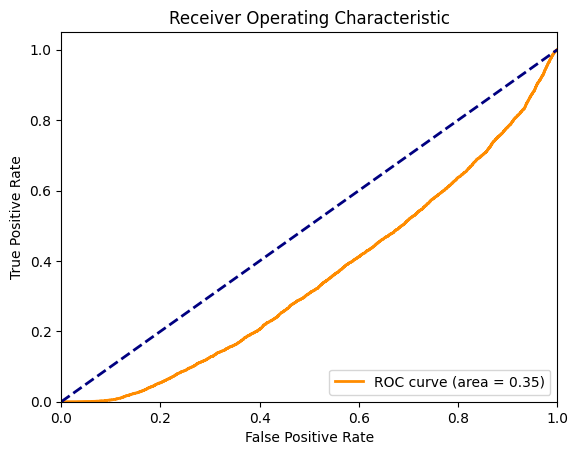

In [9]:
from sklearn.metrics import roc_auc_score, f1_score

# Assuming you have 'all_preds' and 'all_labels' from the validation phase
auc_score = roc_auc_score(all_labels, all_preds)
f1 = f1_score(all_labels, [1 if p > 0.5 else 0 for p in all_preds])

print(f"Patient-level AUC: {auc_score:.3f}")
print(f"Patient-level F1 score: {f1:.3f}")

fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Data for total number of patches classified as MSI or MSS
total_patches = {
    "MSI": 100,  # Example number
    "MSS": 200   # Example number
}

# Data for patient level MSI percentages
patients_msi_percentage = {
    "TCGA-A6-2686": 0.7508833922261484,
    "TCGA-AA-3715": 0.2551622418879056,
    "TCGA-AA-3821": 0.9005328596802842,
    "TCGA-AA-3864": 0.6898638426626323,
    "TCGA-D5-6927": 0.5754716981132075,
    "TCGA-G4-6320": 0.8928571428571429,
    "TCGA-A6-2681": 0.6698564593301436,
    "TCGA-A6-A565": 0.3939393939393939,
    "TCGA-AA-3851": 0.9633333333333334,
    "TCGA-AA-3968": 0.937888198757764,
    "TCGA-AA-3976": 0.9356223175965666,
    "TCGA-AD-6901": 0.9142857142857143,
    "TCGA-AF-2693": 0.9148936170212766,
    "TCGA-AG-3878": 0.9936305732484076,
    "TCGA-AG-3896": 0.937984496124031,
    "TCGA-AZ-4308": 0.8713550600343053,
    "TCGA-CK-4948": 0.8019257221458047,
    "TCGA-CM-4747": 0.8112118713932399,
    "TCGA-D5-6531": 0.9831649831649831,
    "TCGA-D5-6534": 0.947856315179606,
    "TCGA-F4-6460": 0.9536354056902002,
    "TCGA-F4-6808": 0.9815837937384899,
    "TCGA-F5-6864": 0.8032454361054767,
    "TCGA-G4-6627": 0.8875793291024479
}

# Plotting the pie chart for total number of patches classified as MSI or MSS
plt.figure(figsize=(14, 7))

# Pie chart
plt.subplot(1, 2, 1)
plt.pie(total_patches.values(), labels=total_patches.keys(), autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title("Total Number of Patches Classified as MSI or MSS")

# Bar chart for patient level MSI percentages
plt.subplot(1, 2, 2)
patients = list(patients_msi_percentage.keys())
percentages = list(patients_msi_percentage.values())

plt.barh(patients, percentages, color='skyblue')
plt.xlabel('MSS Percentage')
plt.title('Patient Level MSS Percentage')
plt.gca().invert_yaxis()  # Optional: to have the first patient on top

plt.tight_layout()
plt.show()
